## Importing Libraries

In [1]:
import cv2
import os
from imutils.video import FPS
import numpy as np
import time
import csv
import pandas as pd
import threading

# import sys
from imutils.video import VideoStream
from keras.models import load_model

from PIL import Image
from keras.preprocessing import image
from multiprocessing import Process, Queue
import time
import matplotlib.pyplot as plt



## Implementing Producer-Consumer

Multi-threading allows us to create 2 seperate threads 
- producer to read frames and place in a queue. 
- And, consumer to read the frames from the queue and perform the queries as specified.

## Pipeline implementation


In [2]:
################################################## start of the pipeline ###############################################

##Load YOLO
net = cv2.dnn.readNet("./Model/darknet/yolov3-tiny.weights",
                       "./Model/darknet/cfg/yolov3-tiny.cfg")

classes = []

with open("./Model/darknet/data/coco.names","r") as f:
    classes = [line.strip() for line in f.readlines()]

layer_names = net.getLayerNames()
outputlayers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
colors= np.random.uniform(0,255,size=(len(classes),3))

## Choose Query 

In [3]:
query = int(input("Select query type:\n\t\t1. Query 1: Object Detector\n\t\t2. Query 2: Attribute classifier - Car Type\n\nEnter your choice:"))

Select query type:
		1. Query 1: Object Detector
		2. Query 2: Attribute classifier - Car Type

Enter your choice:2


## Read the Video and feed frames into Tiny-YOLO

If Query 2 is selected, the bounding boxes from tiny-YOLO are fed into MobileNet for predicting Car Classifier


# Producer - consumer

## Producer Thread

In [4]:
# Producer class
starting_time = time.time()
    
class Producer:
    def __init__(self, q):
        self.q = q
        
    def run(self):
        
        cap = cv2.VideoCapture("./Assignment files/assignment-clip.mp4")
        i = 1
        
        while True:
            flag, frame = cap.read()
            
            if not flag:
                break
                
            self.q.put(frame)
#             time.sleep(0.001)
            print("\nproduced frame: ",i)
            i+=1

## Consumer Thread

In [5]:
# Consumer thread
class Consumer:
    def __init__(self, q):
        self.q = q

    def run(self):
               
        from keras.models import load_model
        
        # non- optimised model
        #model = load_model('./Retrained MobileNet Models/Final_modelN_89_87.h5')
  
        #optimised model
        model = load_model('./Retrained MobileNet Models/Final-model-10.h5')

        fourcc = cv2.VideoWriter_fourcc(*"mp4v")

        if (query == 2):
            writer = cv2.VideoWriter("./Outputs/Optimised Pipeline/Optimised_query2.mp4", 
                                     fourcc, 30,(428, 576))

        else:
            writer = cv2.VideoWriter("./Outputs/Optimised Pipeline/Optimised_query1.mp4", 
                                     fourcc, 30,(428, 576))

        font = cv2.FONT_HERSHEY_SIMPLEX 

        frame_id = 0

        if (query == 2):
            frame_no2 = 0
            frame_time2 = 0

        else:
            frame_no1 = 0
            frame_time1 = 0

        if (query == 2):
            with open('./Outputs/Optimised Pipeline/Optimised_query2.csv', mode='a') as car_frame:
                car_writer = csv.writer(car_frame, delimiter=',')
                car_writer.writerow(["Frame#","sedan#","SUV#","Frame#","Frame_time#","FPS"])

        else:
            with open('./Outputs/Optimised Pipeline/Optimised_query1.csv', mode='a') as car_frame:
                car_writer = csv.writer(car_frame, delimiter=',')
                car_writer.writerow(["Frame#","Total cars","Frame#","Frame_time#","FPS"])

        while not self.q.empty():
            
            frame = self.q.get()         # get frames from queue
            #print("Time: ", time)
    
            if frame is None: 
                break
            
            frame_start_time = time.time()
            frame_id+=1

            print("\n                           consumed frame: ",frame_id)

            if (query == 2):
                frame_no2 = frame_id
            else:
                frame_no1 = frame_id

            # extract the frame dimension values
            height,width,channels = frame.shape
    
            #detecting objects
            blob = cv2.dnn.blobFromImage(frame,0.00392,(224,224),(0,0,0),True,crop=False) #reduce 416 to 320    

            net.setInput(blob)
            outs = net.forward(outputlayers)
            
            #Showing info on screen/ get confidence score of algorithm in detecting an object in blob
            class_ids=[]
            confidences=[]
            boxes=[]
    
            for out in outs:
                for detection in out:
                    
                    scores = detection[5:]
                    class_id = np.argmax(scores)
                    confidence = scores[class_id]
            
                    if confidence > 0.3:
                        
                        #object detected
                        center_x = int(detection[0]*width)
                        center_y = int(detection[1]*height)
                        w = int(detection[2]*width)
                        h = int(detection[3]*height)

                        #rectangle co-ordinaters
                        x=int(center_x - (w/2))
                        y=int(center_y - (h/2))
                
                        boxes.append([x,y,w,h])                    #put all rectangle areas
                        confidences.append(float(confidence))      #show confidence percentage of the object detected
                        class_ids.append(class_id)                 #name of the object that was detected

            #Non-Max Supression of rectangles - selecting the box with highest confidence
            indexes = cv2.dnn.NMSBoxes(boxes,confidences,0.3,0.001)

            count_cars = 0
            count_sedan = 0
            count_SUV = 0
    
            for i in range(len(boxes)):
                if i in indexes:
                    x,y,w,h = boxes[i]
                    
                    if (query == 2):
                        ROI = frame[y:y+h, x:x+w]       # select the region of interest - i.e., bounding box
                        if((x,y) < (0,0)):
                            break
                        
                        img = Image.fromarray(ROI, 'RGB')         # convert numpy array back to image
                        # print("                                    img1")
                        img_tensor = image.img_to_array(img)                 # (height, width, channels)
                        img_tensor.resize((224,224,3))               # resize the bounding box image as per the model
                        img_tensor = np.expand_dims(img_tensor, axis=0)   # (1, height, width, channels), 
                        img_tensor /= 255.                            # imshow expects values in the range [0, 1]
                        # print("                                  img_tensor")
                        
                        prediction = model.predict(img_tensor)                                 # predict the car type
            
                        # print(prediction)
              
                        if (prediction[0][0] > 0.5):
                            prediction = "SUV"
                            count_SUV += 1
              
                        elif (prediction[0][0] < 0.5):
                            prediction = "sedan"
                            count_sedan += 1

                    label = str(classes[class_ids[i]])
                    confidence= confidences[i]
                    color = colors[class_ids[i]]
                    cv2.rectangle(frame,(x,y),(x+w,y+h),(255,165,0),2)

                    if (query == 2):
                        box_label = label + ": " + str(round(confidence,2)) + " Type:" + prediction
                    else:
                        box_label = label + ": " + str(round(confidence,2))
            
                    labelSize, baseLine = cv2.getTextSize(box_label, font, 0.5, 1)
                    y = max(y, labelSize[1])
                    cv2.rectangle(frame,(x,y - labelSize[1]),(x + labelSize[0], y + baseLine),(255,165,0), cv2.FILLED)
                    cv2.putText(frame, box_label, (x, y),font, 0.5, (0, 0, 0))
            
                    count_cars += 1
            

            elapsed_time = time.time() - starting_time
            fps = frame_id/elapsed_time

            frame_end_time = time.time() - frame_start_time
        
            if (query == 2):
                frame_time2 = frame_end_time
            else:
                frame_time1 = frame_end_time
    

            cv2.putText(frame,"FPS: "+str(round(fps,2)),(10,50),font,1,(255,255,255),2)
            cv2.putText(frame,"Cars in frame: "+str(count_cars),(10,80),font,1,(255,255,255),2)

            if (query == 2):
                with open('./Outputs/Optimised Pipeline/Optimised_query2.csv', mode='a') as car_frame:
                    car_writer = csv.writer(car_frame, delimiter=',')
                    car_writer.writerow([frame_id,count_sedan,count_SUV,frame_no2,frame_time2,fps])
    
            else:
                with open('./Outputs/Optimised Pipeline/Optimised_query1.csv', mode='a') as car_frame:
                    car_writer = csv.writer(car_frame, delimiter=',')
                    car_writer.writerow([frame_id,count_cars,frame_no1,frame_time1,fps])

   
            #cv2_imshow(frame)
            writer.write(frame)
            key = cv2.waitKey(1) #wait 1ms the loop will start again and we will process the next frame
    
            if key == 27: #esc key stops the process
                break;

        final_time = time.time() - starting_time
        print("Query total time: ",final_time)
  
        print("\n")
        print("closing !!!")


        writer.release()  
        cv2.destroyAllWindows()

## connecting the producer and consumer through a queue and running the pipeline

In [6]:
def main():
    
    #Create queue
    q = Queue(maxsize = 5)
    
    producer = Producer(q)
    producer_thread = threading.Thread(target = producer.run)
    
    consumer = Consumer(q)
    consumer_thread = threading.Thread(target = consumer.run)
    
    producer_thread.start()
    # starting the counter
    consumer_thread.start()

    producer_thread.join()
    consumer_thread.join()
    
if __name__ == "__main__":
    main()


produced frame:  1

produced frame:  2

produced frame:  3

produced frame:  4

produced frame:  5

                           consumed frame:  
produced frame:  6
1

                           consumed frame: 
produced frame:  7
 2

                           consumed frame: 
produced frame:  8
 3

                           consumed frame: 
produced frame:  9
 4

                           consumed frame: 
produced frame:  10
 5

                           consumed frame: 
produced frame:  11
 6

                           consumed frame: 
produced frame:  7
 12

                           consumed frame: 
produced frame:  8
 13

                           consumed frame: 
produced frame:  14
 9

                           consumed frame: 
produced frame:  15
 10

                           consumed frame: 
produced frame:  16
 11

                           consumed frame: 
produced frame:  17
 12

                           consumed frame: 
produced frame:  18
 13

               


                           consumed frame: 
produced frame:  124
 119

                           consumed frame: 
produced frame:  120
 125

                           consumed frame: 
produced frame:   121
126

                           consumed frame: 
produced frame:   127
122

                           consumed frame: 
produced frame:  123
 128

                           consumed frame:  124

produced frame:  129

                           consumed frame:  125

produced frame:  130

                           consumed frame:  126

produced frame:  131

                           consumed frame: 
produced frame:  132
 127

                           consumed frame:  128

produced frame:  133

                           consumed frame: 
produced frame:  129
 134

                           consumed frame: 
produced frame:  130
 135

                           consumed frame:  131

produced frame:  136

                           consumed frame: 
produced frame:  137
 132

     


                           consumed frame:  235

produced frame:  240

                           consumed frame: 
produced frame:  236
 241

                           consumed frame: 
produced frame:  237
 242

                           consumed frame: 
produced frame:   238
243

                           consumed frame:  239

produced frame:  244

                           consumed frame: 
produced frame:  245
 240

                           consumed frame: 
produced frame:  246
 241

                           consumed frame:  242

produced frame:  247

                           consumed frame:  243

produced frame:  248

                           consumed frame:  244

produced frame:  249

                           consumed frame: 
produced frame:  245
 250

                           consumed frame:  246

produced frame:  251

                           consumed frame: 
produced frame:  252 247


                           consumed frame:  248

produced frame:  253

     


produced frame:  355

                           consumed frame: 
produced frame:  356
 351

                           consumed frame: 
produced frame:  357
 352

                           consumed frame: 
produced frame:  353
 358

                           consumed frame:  
produced frame:  359
354

                           consumed frame: 
produced frame:  355
 360

                           consumed frame: 
produced frame:  361
 356

                           consumed frame: 
produced frame:   357
362

                           consumed frame: 
produced frame:   358
363

                           consumed frame: 
produced frame:  364
 359

                           consumed frame: 
produced frame:  360
 365

                           consumed frame: 
produced frame:  366
 361

                           consumed frame: 
produced frame:  362
 367

                           consumed frame: 
produced frame:  368
 363

                           consumed frame: 
produced f


                           consumed frame:  468

produced frame:  473

                           consumed frame:  469

produced frame:  474

                           consumed frame:  470

produced frame:  475

                           consumed frame: 
produced frame:  476
 471

                           consumed frame: 
produced frame:  472
 477

                           consumed frame:  473

produced frame:  478

                           consumed frame:  474

produced frame:  479

                           consumed frame:  
produced frame: 475
 480

                           consumed frame: 
produced frame:  476
 481

                           consumed frame: 
produced frame:  482
 477

                           consumed frame: 
produced frame:  483
 478

                           consumed frame: 
produced frame:   484
479

                           consumed frame:  480

produced frame:  485

                           consumed frame: 
produced frame:  486
 481

     

produced frame:  588
 583

                           consumed frame: 
produced frame:   589584


                           consumed frame: 
produced frame:  590
 585

                           consumed frame: 
produced frame:  591
 586

                           consumed frame: 
produced frame:  592
 587

                           consumed frame: 
produced frame:  593
 588

                           consumed frame: 
produced frame:   589
594

                           consumed frame: 
produced frame:  595 590


                           consumed frame: 
produced frame:  591
 596

                           consumed frame: 
produced frame:  592
 597

                           consumed frame:  593

produced frame:  598

                           consumed frame:  594

produced frame:  599

                           consumed frame: 
produced frame:  595
 600

                           consumed frame: 
produced frame:  596
 601

                           consumed frame: 
produc


                           consumed frame: 
produced frame:  700
 705

                           consumed frame: 
produced frame:  701
 706

                           consumed frame: 
produced frame:  707
 702

                           consumed frame: 
produced frame:  708
 703

                           consumed frame: 
produced frame:  709
 704

                           consumed frame: 
produced frame:  705
 710

                           consumed frame: 
produced frame:  706
 711

                           consumed frame:  707

produced frame:  712

                           consumed frame: 
produced frame:  713
 708

                           consumed frame: 
produced frame:  714
 709

                           consumed frame:  710

produced frame:  715

                           consumed frame: 
produced frame:  716
 711

                           consumed frame: 
produced frame:  717
 712

                           consumed frame: 
produced frame:  718
 713

     


                           consumed frame: 
produced frame:  821
 816

                           consumed frame: 
produced frame:  817 822


                           consumed frame: 
produced frame:  823
 818

                           consumed frame: 
produced frame:  824
 819

                           consumed frame: 
produced frame:  820
 825

                           consumed frame: 
produced frame:  821
 826

                           consumed frame: 
produced frame:   827
822

                           consumed frame: 
produced frame:  828
 823

                           consumed frame: 
produced frame:  829
 824

                           consumed frame: 
produced frame:  825
 830

                           consumed frame: 
produced frame:  831
 826

                           consumed frame:  827

produced frame:  832

                           consumed frame: 
produced frame:  828
 833

                           consumed frame: 
produced frame:  834
 829

     

### Query 1 - Event Extraction graph

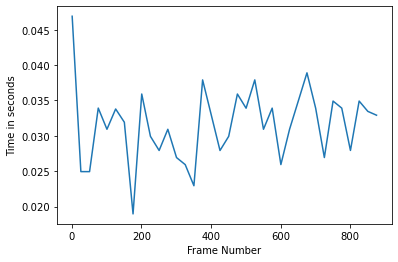

In [7]:
query_1 = pd.read_csv('./Outputs/Optimised Pipeline/Optimised_query1.csv')

plt.plot(query_1['Frame#.1'][::25], query_1['Frame_time#'][::25])
plt.xlabel('Frame Number')
plt.ylabel('Time in seconds')
plt.savefig('./Outputs/Optimised Pipeline/optimised - Query 1 - Event Extraction graph.jpg')
plt.show()


### Query 1 - Throughput graph

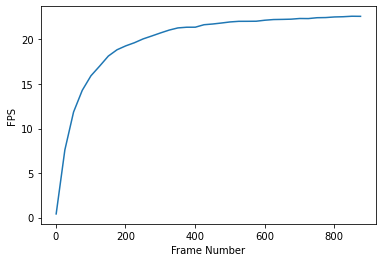

In [8]:
plt.plot(query_1['Frame#.1'][::25], query_1['FPS'][::25])
plt.xlabel('Frame Number')
plt.ylabel('FPS')
plt.savefig('./Outputs/Optimised Pipeline/Optimised - Query 1 - Throughput graph.jpg')
plt.show()


### Query 2 - Event Extraction graph

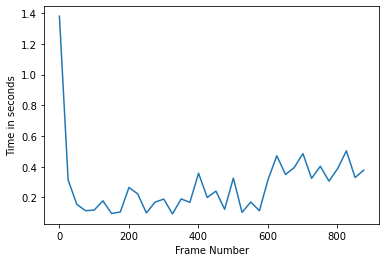

In [9]:
query_2 = pd.read_csv('./Outputs/Optimised Pipeline/Optimised_query2.csv')

plt.plot(query_2['Frame#.1'][::25], query_2['Frame_time#'][::25])
plt.xlabel('Frame Number')
plt.ylabel('Time in seconds')
plt.savefig('./Outputs/Optimised Pipeline/Optimised - Query 2 - Event Extraction graph.jpg')
plt.show()


### Query 2 - Throughput graph

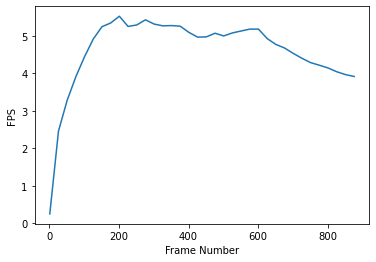

In [10]:
plt.plot(query_2['Frame#.1'][::25], query_2['FPS'][::25])
plt.xlabel('Frame Number')
plt.ylabel('FPS')
plt.savefig('./Outputs/Optimised Pipeline/Optimised - Query 2 - Throughput graph.jpg')
plt.show()
